In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import ipdb

In [2]:
class KF(object):
    def __init__(self, dim_x, dim_y, R, P, Q, F, H):  # x0 means initial state
        if dim_x < 1:
            raise ValueError('dim_x must be 1 or greater')
        if dim_y < 1:
            raise ValueError('dim_z must be 1 or greater')

        self.dim_x = dim_x  # integer
        self.dim_y = dim_y  # integer
        self.R = R
        self.P = P
        self.Q = Q
        self.F = F
        self.H = H
        self.x = np.array([[0], [0]])  # x is a vector, n by 1

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):  # z is measured data
        y = z - self.H @ self.x  # x here is the prior state
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)  # kalman gain
        self.y = y
        self.K = K
        
        self.x = self.x + K @ y
        self.P = self.P - K @ self.H @ self.P  # K here is the posterior K

In [3]:
def read_output(No, linkNO, laneNO):
    result_dir = r'C:\Users\Kaihang Zhang\Desktop\Vissim_Projects\network_from_SimonHu_Queue_Estimation\Queue_Estimation\real-world-network\results\\'
    #result_dir = '/Volumes/Files/QueueEstimation/Results20200627_real_network/'

    # for which senario
    # No = int(input('No:\n'))
    
    if No < 10:
        No = '00' + str(No)
    elif No > 9 and No < 100:
        No = '0' + str(No)
    else:
        No = str(No)

    print('Reading file...No%s' % No)


    filename = result_dir + 'real-world-network_' + No + '.fzp'
    start_line = 25  # depends on number of variables, include title line
    line_NO = 0
    output = []
    with open(filename) as file:
        for line in file:
            line_NO += 1
            if line_NO <= start_line:
                continue
            line_data = line.strip('$').strip().split(';')
            try:
                if line_data [4] == str(linkNO) and line_data[5] == str(laneNO):
                    output.append(line_data)
                elif line_NO == start_line + 1:
                    output.append(line_data)
            except:
                None
            
    titles = output[0]
    output = np.array(output[1:])
    output = pd.DataFrame(output, columns=titles)

    int_set = ['NO', 'VEHTYPE', r'LANE\LINK\NO', r'LANE\INDEX']
    output[int_set] = output[int_set].astype('int32')
    
    float_set = ['VEHICLE:SIMSEC', 'STARTTM', 'COORDFRONTX', 'COORDFRONTY', 'SPEED', 'ACCELERATION', 'POS']
    output[float_set] = output[float_set].astype('float64')

    #output = output.sort_values(by=['NO', 'VEHICLE:SIMSEC'])
    #output.index = pd.Series(np.arange(0, output.shape[0], 1))
    
    #output = output.loc[output[r'LANE\LINK\NO'] == linkNO]
    #output = output.loc[output[r'LANE\INDEX'] == laneNO]
    
    output['CYCLE'] = ''
    
    output['CYCLE'] = output['VEHICLE:SIMSEC'] // 60
    
    print('Reading success of No %s' % No)
    return output

In [4]:
def get_stop_data_collection(output):
    output = output.loc[np.abs(output['SPEED']) < 1e-7]
    output = output.sort_values(by=['NO', 'VEHICLE:SIMSEC'])
    
    # drop data between stop and discharge points
    lines_to_be_dropped = []
    for i in range(1, len(output.index)):
        if ( output.loc[output.index[i], 'NO'] == output.loc[output.index[i-1], 'NO'] and output.loc[output.index[i], 'VEHICLE:SIMSEC'] - output.loc[output.index[i-1], 'VEHICLE:SIMSEC'] < 0.15 ):
            lines_to_be_dropped.append(output.index[i])
    output.drop(lines_to_be_dropped, inplace=True)

    # drop data that vehs move a little bit but still in queue
    lines_to_be_dropped = []
    for i in range(1, len(output.index)):
        if np.abs(output.loc[output.index[i], 'POS'] - output.loc[output.index[i-1], 'POS']) < 3:
            lines_to_be_dropped.append(output.index[i])
    output.drop(lines_to_be_dropped, inplace=True)
    
    output = output.sort_values(by=['VEHICLE:SIMSEC', 'NO'])
    
    # adjust the cycle number
    fixing_dict = {}
    for i in range(1, len(output.index)):
        if output.loc[output.index[i], 'POS'] - output.loc[output.index[i-1], 'POS'] < 0:
            output.loc[output.index[i], 'CYCLE'] = output.loc[output.index[i-1], 'CYCLE']
            
        elif output.loc[output.index[i], 'POS'] - output.loc[output.index[i-1], 'POS'] > 0:
            #ipdb.set_trace()
            current_time = output.loc[output.index[i-1], 'VEHICLE:SIMSEC']
            veh_next_40_sec = output.loc[(output['VEHICLE:SIMSEC'] > current_time) & (output['VEHICLE:SIMSEC'] < current_time + 40)]
            
            for j in range(len(veh_next_40_sec.index)):
                if veh_next_40_sec.loc[veh_next_40_sec.index[j], 'POS'] - output.loc[output.index[i-1], 'POS'] < 0:
                    try:
                        fixing_dict[veh_next_40_sec.index[j]] = min(fixing_dict[veh_next_40_sec.index[j]], output.loc[output.index[i-1], 'CYCLE'])
                    except:
                        fixing_dict[veh_next_40_sec.index[j]] = output.loc[output.index[i-1], 'CYCLE']

    for key in fixing_dict.keys():
        output.loc[key, 'CYCLE'] = fixing_dict[key]
    
    output.loc[:, 'CYCLE'] = output.loc[:, 'CYCLE'] + 1
    
    return output

In [5]:
def get_discharging_data_collection(output):
    output = output.loc[np.abs(output['SPEED']) < 1e-7]
    output = output.sort_values(by=['NO', 'VEHICLE:SIMSEC'])
    
    lines_to_be_dropped = []
    for i in range(1, output.shape[0]):
        if ( output.loc[output.index[i], 'NO'] == output.loc[output.index[i-1], 'NO'] and output.loc[output.index[i], 'VEHICLE:SIMSEC'] - output.loc[output.index[i-1], 'VEHICLE:SIMSEC'] < 0.15 ):
            lines_to_be_dropped.append(output.index[i-1])
    output.drop(lines_to_be_dropped, inplace=True)
    
    output = output.sort_values(by=['VEHICLE:SIMSEC', 'NO'])

    lines_to_be_dropped = []
    for i in range(1, len(output.index)):
        if np.abs(output.loc[output.index[i], 'POS'] - output.loc[output.index[i-1], 'POS']) < 3:
            lines_to_be_dropped.append(output.index[i])
        if output.loc[output.index[i], 'POS'] - output.loc[output.index[i-1], 'POS'] < 0:
            output.loc[output.index[i], 'CYCLE'] = output.loc[output.index[i-1], 'CYCLE']
    
    output.drop(lines_to_be_dropped, inplace=True)
    return output

In [6]:
def compute_CAV_sensor_data(x0, R, data_collection_CAV, randseed):  # simulate a sensor to dedect CAV data, return detected data
    np.random.seed(randseed)

    z_std = np.sqrt(R)  # sensor measurement std, dim: 2 by 1
    
    data_collection_CAV['POS_MEAS'] = ''
    data_collection_CAV['POS_MEAS'] = data_collection_CAV['POS'] + np.random.randn(data_collection_CAV.shape[0]) * z_std[0, 0]

    data_collection_CAV['SPEED_MEAS'] = ''
    
    cycles = list(data_collection_CAV['CYCLE'].drop_duplicates())
    for cycle in cycles:
        data_this_cycle = data_collection_CAV.loc[data_collection_CAV['CYCLE']==cycle]
        index_this_cycle = data_this_cycle.index
        for ind in range(len(index_this_cycle)):
            if ind != len(index_this_cycle) - 1:
                pos_next = data_collection_CAV.loc[index_this_cycle[ind + 1], 'POS']
                pos = data_collection_CAV.loc[index_this_cycle[ind], 'POS']
                t_next = data_collection_CAV.loc[index_this_cycle[ind + 1], 'VEHICLE:SIMSEC']
                t = data_collection_CAV.loc[index_this_cycle[ind], 'VEHICLE:SIMSEC']
                data_collection_CAV.loc[index_this_cycle[ind], 'SPEED_MEAS'] = (pos_next - pos) / (t_next - t)
            else:
                data_collection_CAV.loc[index_this_cycle[ind], 'SPEED_MEAS'] = x0[1, 0] + np.random.randn() * z_std[1, 1]
    
    return data_collection_CAV

In [7]:
# modified for queue estimation by Kaihang Zhang
def run_single_cycle(x0, P, R, Q, dt, track, zs, t_track, t_zs, cycle, if_plot):
    """
    track is the actual position of the dog, zs are the 
    corresponding measurements. 
    """
    F = np.array([[1., dt], [0, 1.]])
    H = np.array([[1., 0], [0, 1.]])
    kf = KF(2, 1, R, P, Q, F, H)
    
    if len(t_zs) == 0:  # all the vehs are regular cars
        zs = np.append(zs, x0, axis=1)
        t_zs = np.append(t_zs, t_track[0])
        
        kf.x = x0
    elif np.abs(t_zs[0] - t_track[0]) > 1e-7:  # the first veh is a regular car
        zs = np.insert(zs, [0], x0, axis=1)
        t_zs = np.insert(t_zs, 0, t_track[0])
        
        kf.x = x0  # x0 comes from historical data
    else:  # the first veh is a CAV
        zs[:, [0]] = x0
        kf.x = x0
    
    x_post, cov_post = np.array([[], []]), np.array([[], []])  # x in x_post: [x, dx/dt]
    x_pre = np.array([[], []])

    #ipdb.set_trace()
    # Kalman filter
    for i in range(zs.shape[1]):
        if i == zs.shape[1] - 1:  # the last one, only predict (no further data to do the Kalman)
            del_t = t_track[-1] - t_zs[-1]
            F[0, 1] = del_t
            kf.F = F
            
            kf.predict()
            
            #ipdb.set_trace()
            x_pre = np.append(x_pre, kf.x, axis=1)
        else:
            del_t = t_zs[i+1] - t_zs[i]
            F[0, 1] = del_t
            kf.F = F
            
            kf.predict()
            x_pre = np.append(x_pre, kf.x, axis=1)

            kf.update(zs[:, [i+1]])
            x_post = np.append(x_post, kf.x, axis=1)
            cov_post = np.append(cov_post, kf.x, axis=1)

    #ipdb.set_trace()
    
    
    t_zs_pre = [i for i in t_zs]
    t_zs_pre.append(t_track[-1])
    
    if abs(t_zs[-1] - t_track[-1]) < 1e-7:  # the last veh is a CAV
        t_zs_pre = np.delete(t_zs_pre, -1)
        x_pre = np.delete(x_pre, -1, axis=1)
        
    if if_plot:
        plt.figure(figsize=[30,10])
        plt.grid()
        plt.title('Cycle # %i'%int(cycle))
        plt.xlabel('time/sec')
        plt.ylabel('position/m')
        
        # plot the predicted queue length
        plt.plot(t_zs_pre[1:], x_pre[0, :], 'yo', ms=15)
        # plot the measured data (from CAVs)
        plt.plot(t_zs, zs[0, :], 'go', ms=15)
        # plot the estimated queue length
        try:
            plt.plot(t_zs[1:], x_post[0, :], 'ro', ms=15)
        except:
            None
        
        
        # estimation line, red
        for i in range(len(x_post[0, :])):
            if i == 0:
                plt.plot([t_zs[i], t_zs[i+1]], [zs[0, i], x_post[0, i]], 'r--', lw=.3)
            else:
                plt.plot([t_zs[i], t_zs[i+1]], [x_post[0, i-1], x_post[0, i]], 'r--', lw=.3)
        
        # measurement line, green
        for i in range(len(zs[0, :]) - 1):
            plt.plot([t_zs[i], t_zs[i+1]], [zs[0, i], zs[0, i+1]], 'g--', lw=.3)
        
        # prediction line, yellow
        
        for i in range(len(x_pre[0, :])):
            if i == 0:
                plt.plot([t_zs_pre[i], t_zs_pre[i+1]], [zs[0, i], x_pre[0, i]], 'y--', lw=.3)
            else:
                plt.plot([t_zs_pre[i], t_zs_pre[i+1]], [x_post[0, i-1], x_pre[0, i]], 'y--', lw=.3)


        # plot the real data
        plt.plot(t_track, track, 'bo', ms=5)
    return x_post, np.array(cov_post), x_pre, t_zs_pre

In [8]:
def simulate(x0, cycle, P, R, Q, dt, data_collection_real, data_collection_CAV, if_plot):
    data_collection_real = data_collection_real.loc[data_collection_real['CYCLE']==cycle]
    data_collection_CAV = data_collection_CAV.loc[data_collection_CAV['CYCLE']==cycle]
    
        
    track = np.array(data_collection_real['POS'])
    zs = np.array([np.array(data_collection_CAV['POS_MEAS']), np.array(data_collection_CAV['SPEED_MEAS'])])

    t_track = np.array(data_collection_real['VEHICLE:SIMSEC'])
    t_zs = np.array(data_collection_CAV['VEHICLE:SIMSEC'])

    x_post, cov_post, x_pre, t_zs_pre = run_single_cycle(x0, P, R, Q, dt, track, zs, t_track, t_zs, cycle, if_plot)
    
    x_predict_pos = x_pre[[0], :]
    x_predict_pos = np.insert(x_predict_pos, 0, x0[0, 0])
    
    # extend the x_predict_pos array by interpolation, according to time
    for i in range(1, len(t_track)):
        if t_zs_pre[i] != t_track[i]:
            t_zs_pre = np.insert(t_zs_pre, i, t_track[i])
            predicted_pos = (x_predict_pos[i] - x_predict_pos[i-1])/(t_zs_pre[i+1] - t_zs_pre[i-1])*(t_track[i] - t_zs_pre[i-1]) + x_predict_pos[i-1]
            x_predict_pos = np.insert(x_predict_pos, i, predicted_pos)
    
    # substitute the estimated pos into x_predict_pos
    for i in range(min(len(x_pre[0, :]), len(x_post[0, :]))):
        x_predict_pos[x_predict_pos==x_pre[0, i]] = x_post[0, i]
    

    return x_post, cov_post, x_predict_pos, x_pre, t_zs_pre

In [9]:
def simulate_queue_forming(x0_stop, if_plot, R, P, Q, dt, randseed, stop_data_collection_CAV, stop_data_collection_real):
    # ##########################################################################
    # calculate for queue forming
    # ##########################################################################
    stop_data_collection_CAV = compute_CAV_sensor_data(x0_stop, R, stop_data_collection_CAV, randseed)

    cycles = list(np.unique(np.array(stop_data_collection_real['CYCLE'])))

    x_post_dict = {}
    cov_post_dict = {}
    stop_data_collection_real['Estimated'] = ''
    stop_data_collection_real['Predicted'] = ''

    for cycle in cycles:
        if cycle == cycles[-1]:
            pos = stop_data_collection_real.loc[stop_data_collection_real['CYCLE']==cycle, 'POS']
            stop_data_collection_real.loc[stop_data_collection_real['CYCLE']==cycle, 'Estimated'] = pos
            stop_data_collection_real.loc[stop_data_collection_real['CYCLE']==cycle, 'Predicted'] = pos
            continue
        
            
        x_post, cov_post, x_est_pos, x_pre, t_zs_pre = simulate(x0_stop, cycle, P, R, Q, dt, stop_data_collection_real, stop_data_collection_CAV, if_plot)
        if len(x_est_pos) != 0:
            # the next two lines are just here for storing data
            #x_post_dict['cycle%i'%int(cycle)] = x_post[:, 0]
            #cov_post_dict['cycle%i'%int(cycle)] = cov_post
            stop_data_collection_real.loc[stop_data_collection_real['CYCLE']==cycle, 'Estimated'] = x_est_pos
            
            t = np.array(stop_data_collection_real.loc[stop_data_collection_real['CYCLE']==cycle, 'VEHICLE:SIMSEC'])
            predict_pos = x0_stop[1] * (t - t[0]) + x0_stop[0]  # pure predict by historical data
            stop_data_collection_real.loc[stop_data_collection_real['CYCLE']==cycle, 'Predicted'] = predict_pos
            
    if if_plot:
        #plt.figure(figsize=[15, 5])
        plt.show()


    stop_data_collection_real['EstError'] = ''
    stop_data_collection_real['PreError'] = ''
    
    stop_data_collection_real['EstError'] = ((stop_data_collection_real['POS'] - stop_data_collection_real['Estimated']) ** 2) ** 0.5
    stop_data_collection_real['PreError'] = ((stop_data_collection_real['POS'] - stop_data_collection_real['Predicted']) ** 2) ** 0.5


    EstError_avg = np.mean(stop_data_collection_real.loc[stop_data_collection_real['EstError'] != 0, 'EstError'])
    print('queue forming average from estimation:%.3f'%EstError_avg)
    EstError_std = np.std(stop_data_collection_real.loc[stop_data_collection_real['EstError'] != 0, 'EstError'])
    print('queue forming std from estimation:%.3f'%EstError_std)

    PreError_avg = np.mean(stop_data_collection_real.loc[stop_data_collection_real['PreError'] != 0, 'PreError'])
    print('queue forming average from pure prediction:%.3f'%PreError_avg)
    PreError_std = np.std(stop_data_collection_real.loc[stop_data_collection_real['PreError'] != 0, 'PreError'])
    print('queue forming std from pure prediction:%.3f'%PreError_std)
    
    return EstError_avg, EstError_std, PreError_avg, PreError_std



In [10]:
def simulate_queue_discharging(x0_discharging, if_plot, R, P, Q, dt, randseed, discharging_data_collection_CAV, discharging_data_collection_real):
    # ##########################################################################
    # calculate for queue discharging
    # ##########################################################################
    discharging_data_collection_CAV = compute_CAV_sensor_data(x0_discharging, R, discharging_data_collection_CAV, randseed)

    cycles = list(np.unique(np.array(discharging_data_collection_real['CYCLE'])))

    x_post_dict = {}
    cov_post_dict = {}
    discharging_data_collection_real['Estimated'] = ''
    discharging_data_collection_real['Predicted'] = ''

    for cycle in cycles:
        if cycle == cycles[-1]:
            pos = discharging_data_collection_real.loc[discharging_data_collection_real['CYCLE']==cycle, 'POS']
            discharging_data_collection_real.loc[discharging_data_collection_real['CYCLE']==cycle, 'Estimated'] = pos
            discharging_data_collection_real.loc[discharging_data_collection_real['CYCLE']==cycle, 'Predicted'] = pos
            continue
            
        x_post, cov_post, x_est_pos, x_pre, t_zs_pre = simulate(x0_discharging, cycle, P, R, Q, dt, discharging_data_collection_real, discharging_data_collection_CAV, if_plot)
        if len(x_est_pos) != 0:
            # the next two lines are just here for storing data
            #x_post_dict['cycle%i'%int(cycle)] = x_post[:, 0]
            #cov_post_dict['cycle%i'%int(cycle)] = cov_post
            
            discharging_data_collection_real.loc[discharging_data_collection_real['CYCLE']==cycle, 'Estimated'] = x_est_pos
                
            t = np.array(discharging_data_collection_real.loc[discharging_data_collection_real['CYCLE']==cycle, 'VEHICLE:SIMSEC'])
            predict_pos = x0_discharging[1] * (t - t[0]) + x0_discharging[0]  # pure predict by historical data
            discharging_data_collection_real.loc[discharging_data_collection_real['CYCLE']==cycle, 'Predicted'] = predict_pos
        
            
    if if_plot:
        #plt.figure(figsize=[15, 5])
        plt.show()


    discharging_data_collection_real['EstError'] = ''
    discharging_data_collection_real['PreError'] = ''
    
    discharging_data_collection_real['EstError'] = ((discharging_data_collection_real['POS'] - discharging_data_collection_real['Estimated']) ** 2) ** 0.5
    discharging_data_collection_real['PreError'] = ((discharging_data_collection_real['POS'] - discharging_data_collection_real['Predicted']) ** 2) ** 0.5


    EstError_avg = np.mean(discharging_data_collection_real.loc[discharging_data_collection_real['EstError'] != 0, 'EstError'])
    print('queue forming average from estimation:%.3f'%EstError_avg)
    EstError_std = np.std(discharging_data_collection_real.loc[discharging_data_collection_real['EstError'] != 0, 'EstError'])
    print('queue forming std from estimation:%.3f'%EstError_std)

    PreError_avg = np.mean(discharging_data_collection_real.loc[discharging_data_collection_real['PreError'] != 0, 'PreError'])
    print('queue forming average from pure prediction:%.3f'%PreError_avg)
    PreError_std = np.std(discharging_data_collection_real.loc[discharging_data_collection_real['PreError'] != 0, 'PreError'])
    print('queue forming std from pure prediction:%.3f'%PreError_std)
    
    return EstError_avg, EstError_std, PreError_avg, PreError_std




# Start simulation

In [11]:
# from 59 to 70, expt for 61
No = 65
linkNO = 25
laneNO = 1
output_real = read_output(No, linkNO, laneNO)
#output_CAV = output_real.loc[output_real['VEHTYPE'] == 112]  # vehicle type depends on settings
pr = '50%'

Reading file...No065
Reading success of No 065


In [12]:
stop_data_collection_real = get_stop_data_collection(output_real)
discharging_data_collection_real = get_discharging_data_collection(output_real)

stop_data_collection_CAV = stop_data_collection_real.loc[stop_data_collection_real['VEHTYPE']==112]
discharging_data_collection_CAV = discharging_data_collection_real.loc[discharging_data_collection_real['VEHTYPE']==112]

In [13]:
# simulate the sensor data from CAVs
if_plot = 0

R = np.array([[10 ** 2, 0], [0, 2 ** 2]])
P = np.diag([500., 49.])  # the initial covarience matrix
Q = 1
dt = 0.1

randseed = 11

x0_stop = np.array([[225], [-3]])
x0_discharging = np.array([[225], [-6]])

t_left = 0
t_right = 950

# Two demos

In [14]:
simulate_queue_forming(x0_stop, if_plot, R, P, Q, dt, randseed, stop_data_collection_CAV, stop_data_collection_real)

'黄点是prediction，红点是estimation，绿点是measurement，蓝点是actual position'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

queue forming average from estimation:7.100
queue forming std from estimation:12.748
queue forming average from pure prediction:12.554
queue forming std from pure prediction:14.044


'黄点是prediction，红点是estimation，绿点是measurement，蓝点是actual position'

In [15]:
simulate_queue_discharging(x0_discharging, if_plot, R, P, Q, dt, randseed, discharging_data_collection_CAV, discharging_data_collection_real)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

queue forming average from estimation:4.057
queue forming std from estimation:3.793
queue forming average from pure prediction:6.569
queue forming std from pure prediction:11.098


(4.05748114691044, 3.7929206177275585, 6.568848314606752, 11.097737322248255)

# Run 15 times with different random seeds, then calculate the average

In [16]:
Result_dict = {}

In [17]:
EstError_avg_f_list, EstError_std_f_list, MeaError_avg_f_list, MeaError_std_f_list = [], [], [], []

for randseed in range(15):
    EstError_avg, EstError_std, MeaError_avg, MeaError_std = simulate_queue_forming(x0_stop, if_plot, R, P, Q, dt, randseed, stop_data_collection_CAV, stop_data_collection_real)

    EstError_avg_f_list.append(EstError_avg)
    EstError_std_f_list.append(EstError_std)
    MeaError_avg_f_list.append(MeaError_avg)
    MeaError_std_f_list.append(MeaError_std)
    


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

queue forming average from estimation:7.544
queue forming std from estimation:13.051
queue forming average from pure prediction:12.554
queue forming std from pure prediction:14.044
queue forming average from estimation:6.352
queue forming std from estimation:11.382
queue forming average from pure prediction:12.554
queue forming std from pure prediction:14.044
queue forming average from estimation:7.360
queue forming std from estimation:13.135
queue forming average from pure prediction:12.554
queue forming std from pure prediction:14.044
queue forming average from estimation:6.760
queue forming std from estimation:12.043
queue forming average from pure prediction:12.554
queue forming std from pure prediction:14.044
queue forming average from estimation:7.217
queue forming std from estimation:12.129
queue forming average from pure prediction:12.554
queue forming std from pure prediction:14.044
queue forming average from estimation:7.734
queue forming std from estimation:11.665
queue form

In [18]:
temp_re = []
print(np.mean(EstError_avg_f_list))
temp_re.append(np.mean(EstError_avg_f_list))
print(np.mean(EstError_std_f_list))
#temp_re.append(np.mean(EstError_std_f_list))
print(np.mean(MeaError_avg_f_list))
temp_re.append(np.mean(MeaError_avg_f_list))
print(np.mean(MeaError_std_f_list))
#temp_re.append(np.mean(MeaError_std_f_list))

Result_dict['Q_forming'] = temp_re

7.286042182196459
12.315781205305651
12.55374269005845
14.043964490977976


In [19]:
EstError_avg_f_list, EstError_std_f_list, MeaError_avg_f_list, MeaError_std_f_list = [], [], [], []

for randseed in range(15):
    EstError_avg, EstError_std, MeaError_avg, MeaError_std = simulate_queue_discharging(x0_discharging, if_plot, R, P, Q, dt, randseed, discharging_data_collection_CAV, discharging_data_collection_real)

    EstError_avg_f_list.append(EstError_avg)
    EstError_std_f_list.append(EstError_std)
    MeaError_avg_f_list.append(MeaError_avg)
    MeaError_std_f_list.append(MeaError_std)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

queue forming average from estimation:4.104
queue forming std from estimation:3.639
queue forming average from pure prediction:6.569
queue forming std from pure prediction:11.098
queue forming average from estimation:3.394
queue forming std from estimation:3.017
queue forming average from pure prediction:6.569
queue forming std from pure prediction:11.098
queue forming average from estimation:4.463
queue forming std from estimation:3.820
queue forming average from pure prediction:6.569
queue forming std from pure prediction:11.098
queue forming average from estimation:3.847
queue forming std from estimation:3.348
queue forming average from pure prediction:6.569
queue forming std from pure prediction:11.098
queue forming average from estimation:4.288
queue forming std from estimation:3.796
queue forming average from pure prediction:6.569
queue forming std from pure prediction:11.098
queue forming average from estimation:3.812
queue forming std from estimation:3.425
queue forming average

In [20]:
temp_re = []

print(np.mean(EstError_avg_f_list))
temp_re.append(np.mean(EstError_avg_f_list))
print(np.mean(EstError_std_f_list))
#temp_re.append(np.mean(EstError_std_f_list))
print(np.mean(MeaError_avg_f_list))
temp_re.append(np.mean(MeaError_avg_f_list))
print(np.mean(MeaError_std_f_list))
#temp_re.append(np.mean(MeaError_std_f_list))

Result_dict['Q_discharging'] = temp_re

4.165565151971263
3.67047355938288
6.568848314606753
11.097737322248257


# Visualization

In [21]:
cycles = list(stop_data_collection_real['CYCLE'].drop_duplicates())

In [22]:
t_start = 0
t_end = 1800

stop_plot = stop_data_collection_real.loc[(stop_data_collection_real['VEHICLE:SIMSEC']>t_start) & (stop_data_collection_real['VEHICLE:SIMSEC']<t_end)]
stop_pos_est = stop_plot['Estimated']
stop_pos_real = stop_plot['POS']
t_stop_pos_est = stop_plot['VEHICLE:SIMSEC']

stop_plot_CAV = stop_plot.loc[stop_plot['VEHTYPE']==112]
stop_pos_est_CAV = stop_plot_CAV['Estimated']
stop_pos_CAV = stop_plot_CAV['POS']
t_stop_pos_CAV = stop_plot_CAV['VEHICLE:SIMSEC']





discharging_plot = discharging_data_collection_real.loc[(discharging_data_collection_real['VEHICLE:SIMSEC']>t_start) & (discharging_data_collection_real['VEHICLE:SIMSEC']<t_end)]
discharging_pos_est = discharging_plot['Estimated']
discharging_pos_real = discharging_plot['POS']
t_discharging_pos_est = discharging_plot['VEHICLE:SIMSEC']

discharging_plot_CAV = discharging_plot.loc[discharging_plot['VEHTYPE']==112]
discharging_pos_est_CAV = discharging_plot_CAV['Estimated']
t_discharging_pos_est_CAV = discharging_plot_CAV['VEHICLE:SIMSEC']

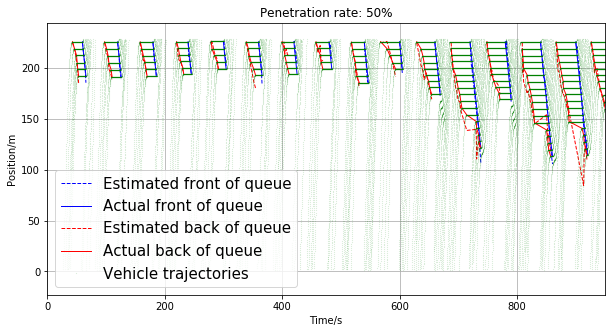

In [23]:
plt.figure(figsize=[10, 5])
#plt.plot(t_discharging_pos_est, discharging_pos_est, '.', color='black', ms=5, label='Position of CVs, estimated')


for cycle in cycles:
    temp = discharging_data_collection_real.loc[discharging_data_collection_real['CYCLE']==cycle]
    t = temp['VEHICLE:SIMSEC']
    pos_est = temp['Estimated']
    plt.plot(t, pos_est, 'b--', lw=1)
    pos_real = temp['POS']
    plt.plot(t, pos_real, 'b', lw=1)

plt.plot(t, pos_est, 'b--', lw=1, label='Estimated front of queue')
plt.plot(t, pos_real, 'b', lw=1, label='Actual front of queue')



#plt.plot(t_stop_pos_est, stop_pos_est, '.', color='black', ms=5, label='Position of CVs, estimated')


for cycle in cycles:
    temp = stop_data_collection_real.loc[stop_data_collection_real['CYCLE']==cycle]
    t = temp['VEHICLE:SIMSEC']
    pos_est = temp['Estimated']
    plt.plot(t, pos_est, 'r--', lw=1)
    pos_real = temp['POS']
    plt.plot(t, pos_real, 'r', lw=1)

plt.plot(t, pos_est, 'r--', lw=1, label='Estimated back of queue')
plt.plot(t, pos_real, 'r', lw=1, label='Actual back of queue')



output_plot = output_real.loc[(output_real['VEHICLE:SIMSEC']>t_start) & (output_real['VEHICLE:SIMSEC']<t_end)]
t = output_plot['VEHICLE:SIMSEC']
pos = output_plot['POS']
plt.plot(t, pos, 'g.', ms=.1, label='Vehicle trajectories')
plt.legend(fontsize=15)
plt.ylabel('Position/m')
plt.xlabel('Time/s')
#plt.xlim(t_start, t_end)
plt.grid()
plt.title('Penetration rate: ' + pr)
#plt.ylim([0, 240])
plt.xlim([t_left, t_right])

re_dir = 'C:\\Users\\Kaihang Zhang\\Desktop\\queue_estimation_results\\%s\\'%(pr[:-1])
plt.savefig(re_dir + pr + '.jpg')

# Calculating queue length = stopping position (back of queue) - discharging position (front of queue)

# Two functions for interpolation

In [24]:
# a function that input a time, return the number of interval this time should be in
def get_interval(t_set, time):
    if time > t_set[-1]:
        return len(t_set)
    for i in range(len(t_set) - 1):
        if (time > t_set[i] and time <= t_set[i+1]):
            return i + 1
    
    return 0

In [25]:
def f_line(kb_list, t):
    return kb_list[0] * t + kb_list[1]

# Two dictionaries storing functionalized (piecewise functions) parameters, for real data.

In [26]:
forming_func_dict_real = {}

for cycle in cycles:
    temp_forming = stop_data_collection_real.loc[stop_data_collection_real['CYCLE']==cycle]
    ind = temp_forming.index
    time_interval = list(temp_forming['VEHICLE:SIMSEC'])
    func_par = []
    for i in range(len(ind) - 1):
        t = temp_forming.loc[ind[i], 'VEHICLE:SIMSEC']
        t_n = temp_forming.loc[ind[i+1], 'VEHICLE:SIMSEC']
        back = temp_forming.loc[ind[i], 'POS']
        back_n = temp_forming.loc[ind[i+1], 'POS']
        
        k = (back_n - back)/(t_n - t)
        b = (back*t_n - back_n*t)/(t_n - t)
        
        func_par.append([k, b])
        
    forming_func_dict_real['cycle_%i'%cycle] = [time_interval, func_par]

In [27]:
discharging_func_dict_real = {}

for cycle in cycles:
    temp_discharging = discharging_data_collection_real.loc[discharging_data_collection_real['CYCLE']==cycle]
    ind = temp_discharging.index
    time_interval = list(temp_discharging['VEHICLE:SIMSEC'])
    func_par = []
    for i in range(len(ind) - 1):
        t = temp_discharging.loc[ind[i], 'VEHICLE:SIMSEC']
        t_n = temp_discharging.loc[ind[i+1], 'VEHICLE:SIMSEC']
        front = temp_discharging.loc[ind[i], 'POS']
        front_n = temp_discharging.loc[ind[i+1], 'POS']
        
        k = (front_n - front)/(t_n - t)
        #b = (front*t_n - front_n*t)/(t_n - t)
        b = -k*t+front
        
        func_par.append([k, b])
        
    discharging_func_dict_real['cycle_%i'%cycle] = [time_interval, func_par]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


# Two dictionaries storing functionalized (piecewise functions) parameters, for estimation.

In [28]:
forming_func_dict = {}

for cycle in cycles:
    temp_forming = stop_data_collection_real.loc[stop_data_collection_real['CYCLE']==cycle]
    ind = temp_forming.index
    time_interval = list(temp_forming['VEHICLE:SIMSEC'])
    func_par = []
    for i in range(len(ind) - 1):
        t = temp_forming.loc[ind[i], 'VEHICLE:SIMSEC']
        t_n = temp_forming.loc[ind[i+1], 'VEHICLE:SIMSEC']
        back = temp_forming.loc[ind[i], 'Estimated']
        back_n = temp_forming.loc[ind[i+1], 'Estimated']
        
        k = (back_n - back)/(t_n - t)
        b = (back*t_n - back_n*t)/(t_n - t)
        
        func_par.append([k, b])
        
    forming_func_dict['cycle_%i'%cycle] = [time_interval, func_par]

In [29]:
discharging_func_dict = {}

for cycle in cycles:
    temp_discharging = discharging_data_collection_real.loc[discharging_data_collection_real['CYCLE']==cycle]
    ind = temp_discharging.index
    time_interval = list(temp_discharging['VEHICLE:SIMSEC'])
    func_par = []
    for i in range(len(ind) - 1):
        t = temp_discharging.loc[ind[i], 'VEHICLE:SIMSEC']
        t_n = temp_discharging.loc[ind[i+1], 'VEHICLE:SIMSEC']
        front = temp_discharging.loc[ind[i], 'Estimated']
        front_n = temp_discharging.loc[ind[i+1], 'Estimated']
        
        k = (front_n - front)/(t_n - t)
        #b = (front*t_n - front_n*t)/(t_n - t)
        b = -k*t+front
        
        func_par.append([k, b])
        
    discharging_func_dict['cycle_%i'%cycle] = [time_interval, func_par]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


# Two dictionaries storing functionalized (linear functions) parameters, for prediction. 

In [30]:
forming_func_dict_pre = {}

for cycle in cycles:
    temp_forming = stop_data_collection_real.loc[stop_data_collection_real['CYCLE']==cycle]
    
    t_0 = list(temp_forming['VEHICLE:SIMSEC'])[0]
    back_0 = 225
    
    func_par = []
    
    k = -3
    b = k*t_0 + back_0
    func_par=[k, b]
    
    forming_func_dict_pre['cycle_%i'%cycle] = func_par

In [31]:
discharging_func_dict_pre = {}

for cycle in cycles:
    temp_discharging = discharging_data_collection_real.loc[discharging_data_collection_real['CYCLE']==cycle]

    t_0 = list(temp_discharging['VEHICLE:SIMSEC'])[0]
    front_0 = 225
    
    func_par = []
    
    k = -3
    b = k*t_0 + front_0
    func_par=[k, b]
    
    discharging_func_dict_pre['cycle_%i'%cycle] = func_par

# Calculate the corresponding front_est/ back_est, and front_pre/ back_pre

In [32]:
stop_data_collection_real['front_est'] = ''
stop_data_collection_real['front_pre'] = ''
stop_data_collection_real['front_real'] = ''

stop_data_collection_real['queue_length_est'] = ''
stop_data_collection_real['queue_length_real'] = ''
stop_data_collection_real['queue_length_pre'] = ''


ind = stop_data_collection_real.index


for cycle in cycles:
    temp_df = stop_data_collection_real.loc[stop_data_collection_real['CYCLE']==cycle]
    
    func_data = discharging_func_dict['cycle_%i'%cycle]
    t_set = func_data[0]
    par = func_data[1]
    func_data_real = discharging_func_dict_real['cycle_%i'%cycle]
    t_set_real = func_data_real[0]
    par_real = func_data_real[1]
    for i in temp_df.index:
        int_NO = get_interval(t_set, temp_df.loc[i, 'VEHICLE:SIMSEC'])
        if int_NO == 0:
            stop_data_collection_real.loc[i, 'front_pre'] = 225
            stop_data_collection_real.loc[i, 'front_est'] = 225
            stop_data_collection_real.loc[i, 'front_real'] = 225
        else:
            stop_data_collection_real.loc[i, 'front_pre'] = f_line(discharging_func_dict_pre['cycle_%i'%cycle], temp_df.loc[i, 'VEHICLE:SIMSEC'])
            stop_data_collection_real.loc[i, 'front_est'] = f_line(par[int_NO-1], temp_df.loc[i, 'VEHICLE:SIMSEC'])
            stop_data_collection_real.loc[i, 'front_real'] = f_line(par_real[int_NO-1], temp_df.loc[i, 'VEHICLE:SIMSEC'])
            

        #ipdb.set_trace()
        back_est = 225 - stop_data_collection_real.loc[i, 'Estimated']
        front_est = 225 - stop_data_collection_real.loc[i, 'front_est']
        stop_data_collection_real.loc[i, 'queue_length_est'] = max(0, back_est - front_est)


        back_real = 225 - stop_data_collection_real.loc[i, 'POS']
        front_real = 225 - stop_data_collection_real.loc[i, 'front_real']
        stop_data_collection_real.loc[i, 'queue_length_real'] = max(0, back_real - front_real)


        back_pre = 225 - stop_data_collection_real.loc[i, 'Predicted']
        front_pre = 225 - stop_data_collection_real.loc[i, 'front_pre']
        stop_data_collection_real.loc[i, 'queue_length_pre'] = max(0, back_pre - front_pre)
    
    

In [33]:
stop_data_collection_real['est_error'] = ''
stop_data_collection_real['pre_error'] = ''

stop_data_collection_real['est_error'] = np.abs(stop_data_collection_real['queue_length_est'] - stop_data_collection_real['queue_length_real'])
stop_data_collection_real['pre_error'] = np.abs(stop_data_collection_real['queue_length_pre'] - stop_data_collection_real['queue_length_real'])

print(np.mean(stop_data_collection_real['est_error']))
print(np.mean(stop_data_collection_real['pre_error']))



7.092925224063998
11.587879114092708


In [34]:
discharging_data_collection_real['back_est'] = ''
discharging_data_collection_real['back_pre'] = ''
discharging_data_collection_real['back_real'] = ''

discharging_data_collection_real['queue_length_est'] = ''
discharging_data_collection_real['queue_length_real'] = ''
discharging_data_collection_real['queue_length_pre'] = ''


ind = discharging_data_collection_real.index


for cycle in cycles:
    temp_df = discharging_data_collection_real.loc[discharging_data_collection_real['CYCLE']==cycle]
    
    func_data = forming_func_dict['cycle_%i'%cycle]
    t_set = func_data[0]
    par = func_data[1]
    func_data_real = forming_func_dict_real['cycle_%i'%cycle]
    t_set_real = func_data_real[0]
    par_real = func_data_real[1]
    
    for i in temp_df.index:
        int_NO = get_interval(t_set, temp_df.loc[i, 'VEHICLE:SIMSEC'])
        if int_NO >= len(t_set):
            temp_temp_df = stop_data_collection_real.loc[stop_data_collection_real['CYCLE']==cycle]
            discharging_data_collection_real.loc[i, 'back_pre'] = min(temp_temp_df['Predicted'])
            discharging_data_collection_real.loc[i, 'back_est'] = min(temp_temp_df['Estimated'])
            discharging_data_collection_real.loc[i, 'back_real'] = min(temp_temp_df['POS'])
        else:
            discharging_data_collection_real.loc[i, 'back_pre'] = f_line(forming_func_dict_pre['cycle_%i'%cycle], temp_df.loc[i, 'VEHICLE:SIMSEC'])
            discharging_data_collection_real.loc[i, 'back_est'] = f_line(par[int_NO-1], temp_df.loc[i, 'VEHICLE:SIMSEC'])
            discharging_data_collection_real.loc[i, 'back_real'] = f_line(par_real[int_NO-1], temp_df.loc[i, 'VEHICLE:SIMSEC'])
            

        
        back_est = 225 - discharging_data_collection_real.loc[i, 'back_est']
        front_est = 225 - discharging_data_collection_real.loc[i, 'Estimated']
        discharging_data_collection_real.loc[i, 'queue_length_est'] = max(0, back_est - front_est)

        
        back_real = 225 - discharging_data_collection_real.loc[i, 'back_real']
        front_real = 225 - discharging_data_collection_real.loc[i, 'POS']
        discharging_data_collection_real.loc[i, 'queue_length_real'] = max(0, back_real - front_real)

        
        temp_l = list(temp_df.index)
        temp_ind = temp_l.index(i)
        temp_i = temp_l[max(0, temp_ind - 1)]

        back_pre = min(0, 225 - discharging_data_collection_real.loc[i, 'back_pre'])
            
        front_pre = 225 - discharging_data_collection_real.loc[i, 'Predicted']
        discharging_data_collection_real.loc[i, 'queue_length_pre'] = max(0, back_pre - front_pre)
    
    

In [35]:
discharging_data_collection_real['est_error'] = ''
discharging_data_collection_real['pre_error'] = ''

discharging_data_collection_real['est_error'] = np.abs(discharging_data_collection_real['queue_length_est'] - discharging_data_collection_real['queue_length_real'])
discharging_data_collection_real['pre_error'] = np.abs(discharging_data_collection_real['queue_length_pre'] - discharging_data_collection_real['queue_length_real'])

print(np.mean(discharging_data_collection_real['est_error']))
print(np.mean(discharging_data_collection_real['pre_error']))

14.442736657597901
34.69157989493485


# Combine the queue discharging and forming data together into a df

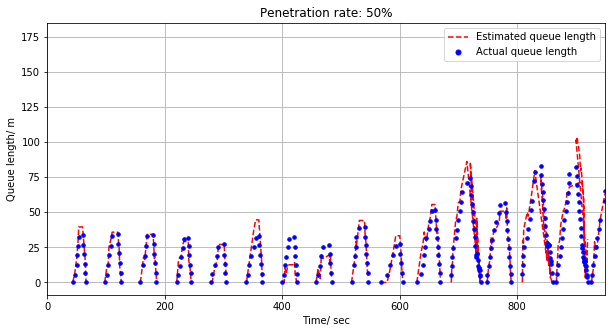

In [36]:
form_test = stop_data_collection_real.loc[stop_data_collection_real.index[:]]
dis_test = discharging_data_collection_real.loc[discharging_data_collection_real.index[:]]

G = form_test.append(dis_test)


plt.figure(figsize=[10, 5])
for cycle in cycles:
    tp_df = G.loc[G['CYCLE']==cycle]
    t = tp_df['VEHICLE:SIMSEC']
    q_est = tp_df['queue_length_est']
    q_pre = tp_df['queue_length_pre']
    q_real = tp_df['queue_length_real']
    
    plt.plot(t, q_est, 'r--')
    #plt.plot(t, q_pre, 'b')
    plt.plot(t, q_real, 'b.', ms=7)

plt.plot(t, q_est, 'r--', label='Estimated queue length')
plt.plot(t, q_real, 'b.', ms=10, label='Actual queue length')

plt.xlim([t_left, t_right])

plt.legend()
plt.xlabel('Time/ sec')
plt.ylabel('Queue length/ m')
plt.grid()
plt.title('Penetration rate: ' + pr)

plt.savefig(re_dir + pr + '_queue.jpg')

In [37]:
temp_re = []

print(np.mean(G['est_error']))
temp_re.append(np.mean(G['est_error']))
print(np.mean(G['pre_error']))
temp_re.append(np.mean(G['pre_error']))

Result_dict['Q_length'] = temp_re

10.84471181356666
23.381400014773636


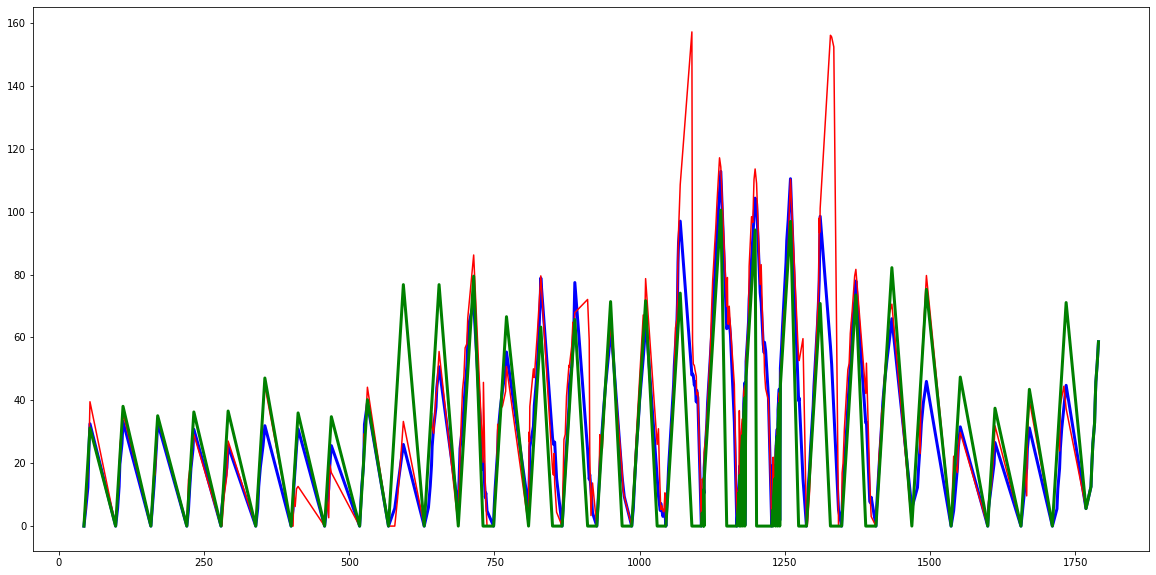

In [38]:
t = stop_data_collection_real['VEHICLE:SIMSEC']
q_l_est = stop_data_collection_real['queue_length_est']
q_l_real = stop_data_collection_real['queue_length_real']
q_l_pre = stop_data_collection_real['queue_length_pre']
back_est = stop_data_collection_real['Estimated']


plt.figure(figsize=[20, 10])
plt.plot(t, q_l_real, 'b', lw=3)
plt.plot(t, q_l_est, 'r')
plt.plot(t, q_l_pre, 'g', lw=3)

# Results

In [39]:
# errors
Result_df = pd.DataFrame(Result_dict, index=['est_error', 'pre_error'])
Result_df.to_csv(re_dir + pr + 'error.csv')

In [40]:
E_cycles = {}

for cycle in cycles:
    temp_df = G.loc[G['CYCLE']==cycle]
    avg_error_est = np.mean(temp_df['est_error'])
    avg_error_pre = np.mean(temp_df['pre_error'])
    max_q_est = max(temp_df['queue_length_est'])
    max_q_real = max(temp_df['queue_length_real'])
    
    E_cycles[cycle] = [avg_error_est, avg_error_pre, max_q_est, max_q_real]

re_df = pd.DataFrame(E_cycles, index=['est_E', 'pre_E', 'max_q_est', 'max_q_real']).stack().unstack(0)

re_df.to_csv(re_dir + pr + '_data_each_cycle.csv')

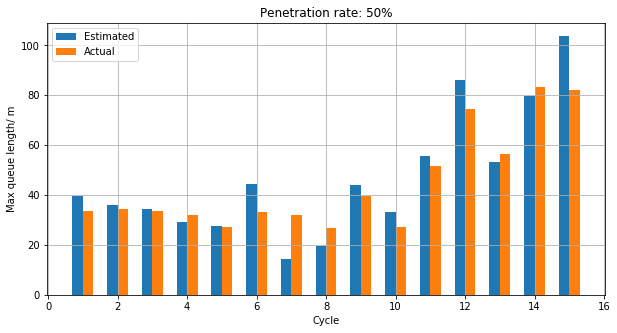

In [41]:
plt.figure(figsize=[10, 5])

plt.bar(re_df.index[:t_right//60]-0.15, re_df['max_q_est'][:t_right//60], width=.3, label='Estimated')
plt.bar(re_df.index[:t_right//60]+0.15, re_df['max_q_real'][:t_right//60], width=.3, label='Actual')
plt.xlabel('Cycle')
plt.ylabel('Max queue length/ m')
plt.grid()
plt.title('Penetration rate: ' + pr)
plt.legend()
#plt.xlim([0, t_right//60])

plt.savefig(re_dir + pr + '_max_q.jpg')

# Next two sections are just for reference

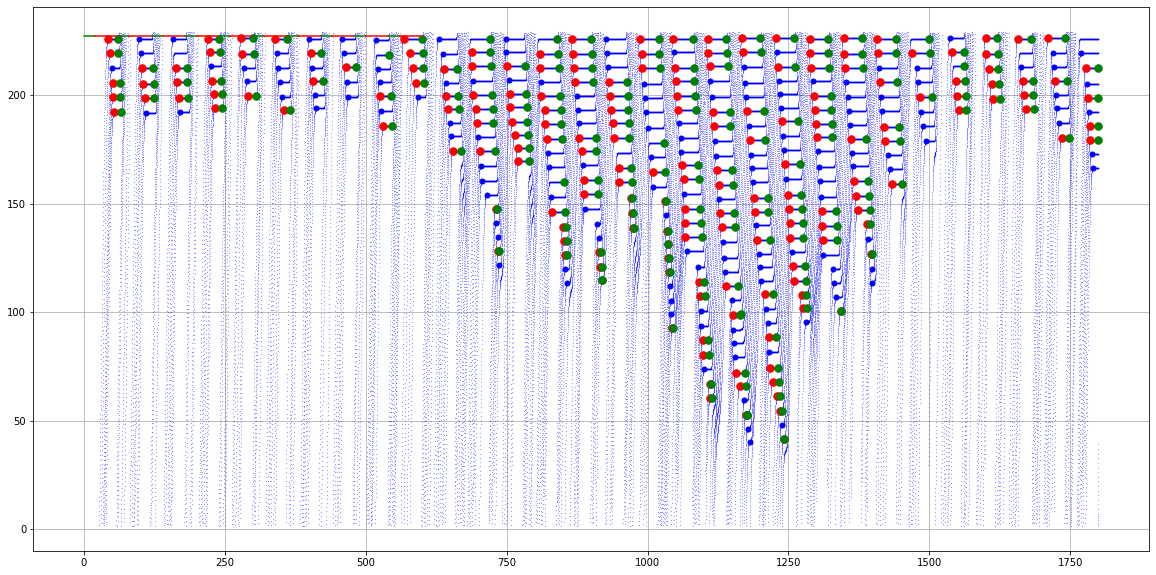

In [42]:
plt.figure(figsize=[20, 10])
t = stop_data_collection_real['VEHICLE:SIMSEC']
pos = stop_data_collection_real['POS']
plt.plot(t, pos, 'b.', ms=10)

t = output_real['VEHICLE:SIMSEC']
pos = output_real['POS']
plt.plot(t, pos, 'b.', ms=.3)


tt = stop_data_collection_CAV['VEHICLE:SIMSEC']
poss = stop_data_collection_CAV['POS']
plt.plot(tt, poss, 'r.', ms=15)

tt = discharging_data_collection_CAV['VEHICLE:SIMSEC']
poss = discharging_data_collection_CAV['POS']
plt.plot(tt, poss, 'g.', ms=15)

sigt_g = []
sigt_r = []
# sigpos = [135]
traffic_head_pos = 227.2
for i in range(10):
    plt.plot([i*60, i*60 + 20], [traffic_head_pos, traffic_head_pos], 'g')
    plt.plot([i*60 + 20, i*60 + 60], [traffic_head_pos, traffic_head_pos], 'r')


plt.grid()
#plt.xlim([1150, 1250])

In [43]:
stop_data_collection_CAV.loc[stop_data_collection_CAV['CYCLE']==6]

,VEHICLE:SIMSEC,STARTTM,NO,VEHTYPE,LANE\LINK\NO,LANE\INDEX,POS,COORDFRONTX,COORDFRONTY,SPEED,ACCELERATION,DESSPEED,INQUEUE,LNCHG,CYCLE,POS_MEAS,SPEED_MEAS
13744,339.0,162.0,374,112,25,1,226.09,671.695,-51.559,0.0,-0.36,68.19,1,None,6.0,207.170877,-2.10318
14688,354.7,184.3,415,112,25,1,193.07,638.734,-49.590,0.0,-0.35,68.27,1,None,6.0,181.348782,-3.90559


In [44]:
temp = output_real.loc[output_real['CYCLE']==13]
temp = temp.loc[temp['SPEED'] < 1e-7]
temp = temp.loc[temp['VEHICLE:SIMSEC'] - 755 < 0]
temp = temp.loc[temp['VEHICLE:SIMSEC'] - 745 > 0]
temp = temp.loc[temp['NO'] > 1000]

temp.sort_values(by=['NO'])

,VEHICLE:SIMSEC,STARTTM,NO,VEHTYPE,LANE\LINK\NO,LANE\INDEX,POS,COORDFRONTX,COORDFRONTY,SPEED,ACCELERATION,DESSPEED,INQUEUE,LNCHG,CYCLE


Text(0, 0.5, 'Position/ m')

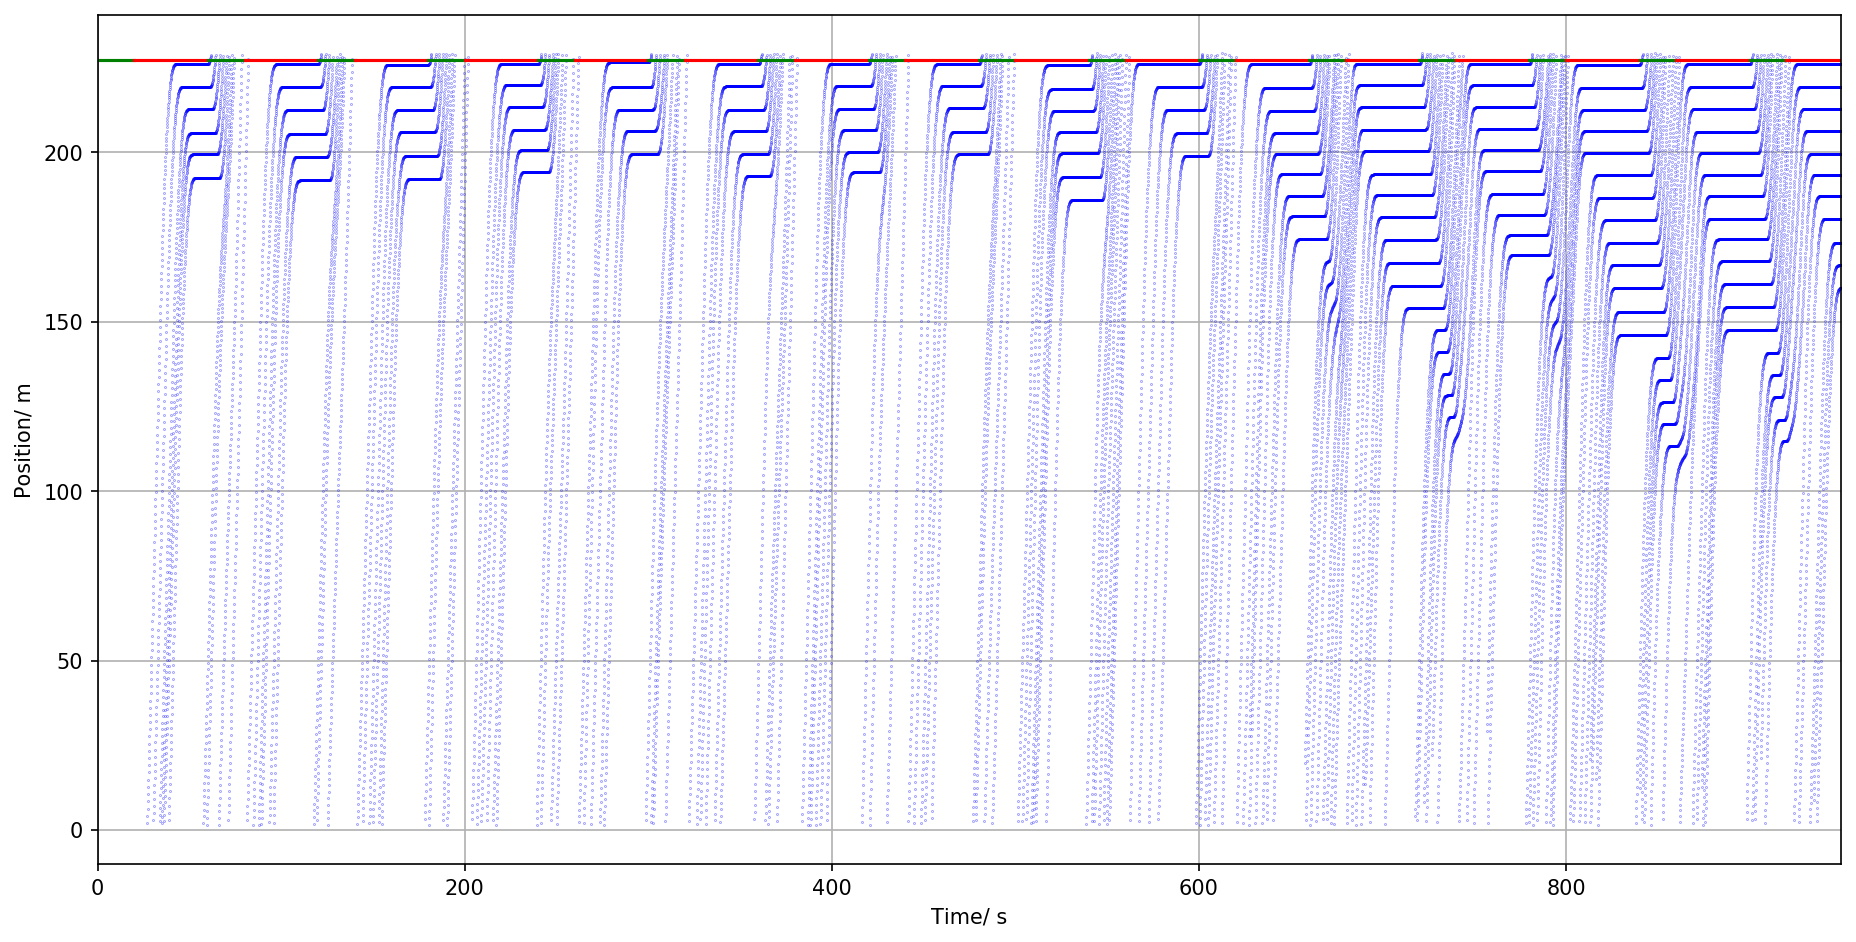

In [62]:
plt.figure(figsize=[15, 7.5], dpi=150)
t = stop_data_collection_real['VEHICLE:SIMSEC']
pos = stop_data_collection_real['POS']
#plt.plot(t, pos, 'b.')

t = output_real['VEHICLE:SIMSEC']
pos = output_real['POS']
plt.plot(t, pos, 'b.', ms=.3)


tt = stop_data_collection_real['VEHICLE:SIMSEC']
poss = stop_data_collection_real['POS']
#plt.plot(tt, poss, 'r.', ms=10)

tt = discharging_data_collection_real['VEHICLE:SIMSEC']
poss = discharging_data_collection_real['POS']
#plt.plot(tt, poss, 'g.', ms=15)

sigt_g = []
sigt_r = []
# sigpos = [135]
for i in range(30):
    plt.plot([i*60, i*60 + 20], [traffic_head_pos, traffic_head_pos], 'g')
    plt.plot([i*60 + 20, i*60 + 60], [traffic_head_pos, traffic_head_pos], 'r')

plt.xlim([t_left, t_right])
plt.grid()
plt.xlabel('Time/ s')
plt.ylabel('Position/ m')

Text(0, 0.5, 'Position/ m')

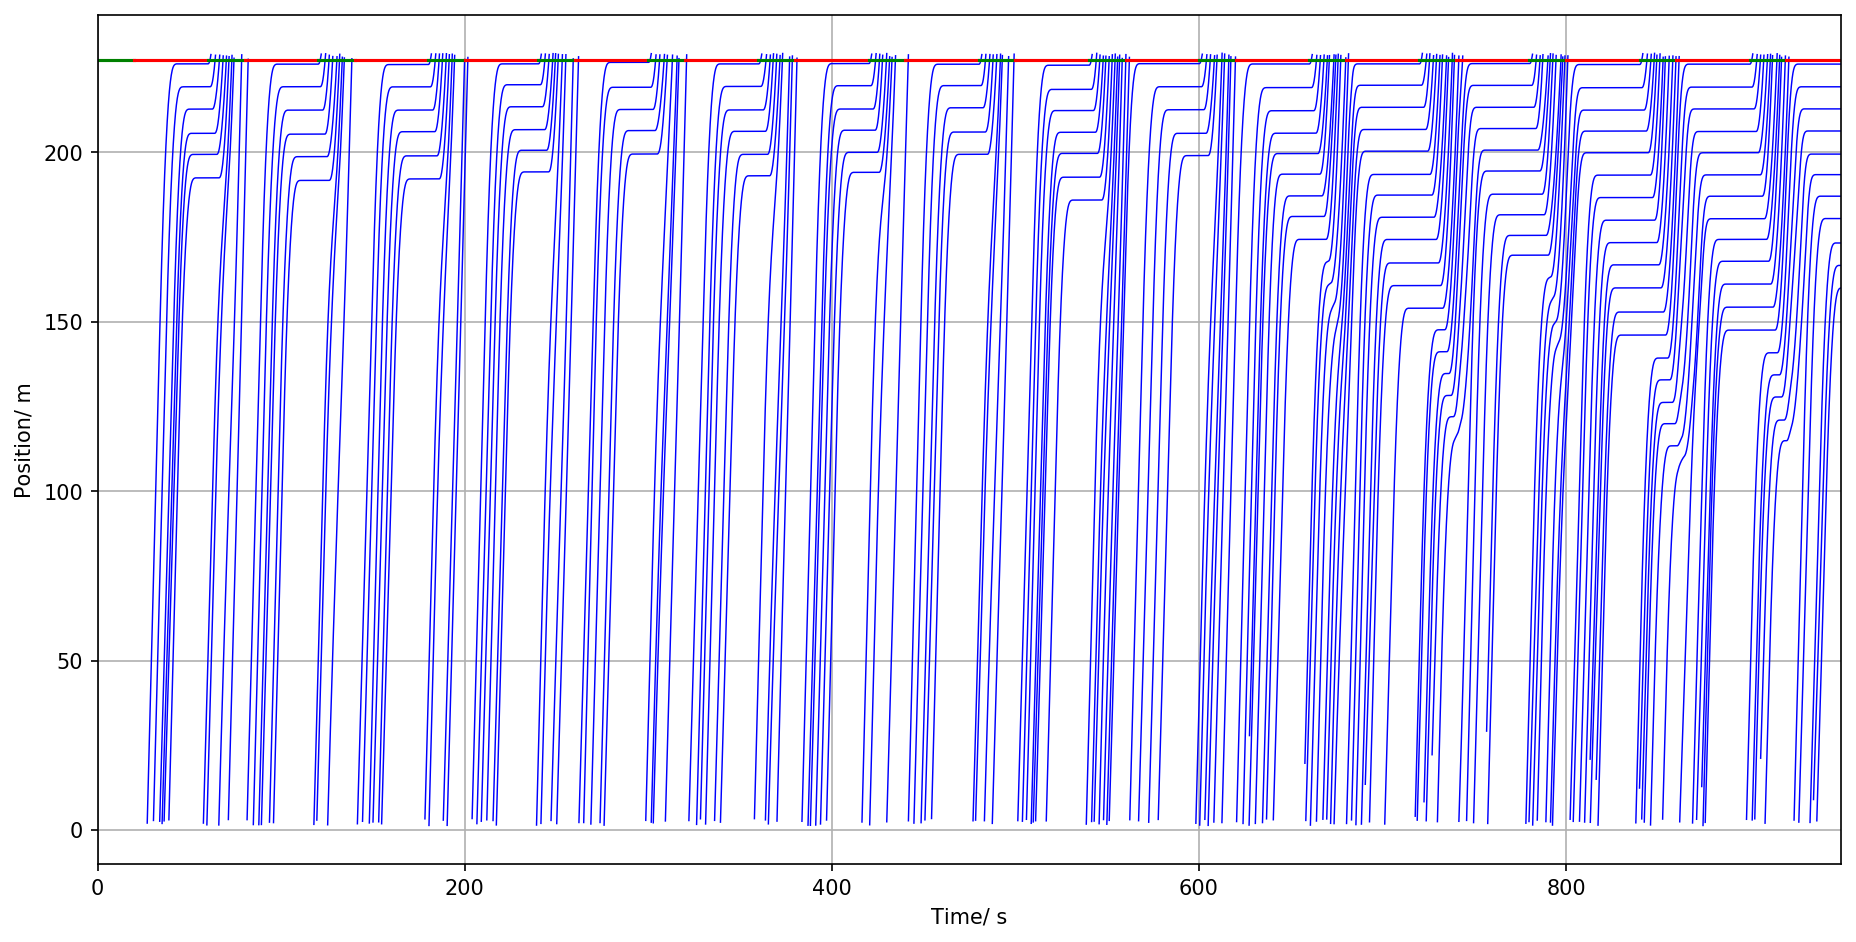

In [63]:
plt.figure(figsize=[15, 7.5], dpi=150)

output_real = output_real.sort_values(by=['NO', 'VEHICLE:SIMSEC'])
NOs = output_real['NO'].drop_duplicates()

for no in NOs:
    temp_df = output_real.loc[output_real['NO']==no]
    t = temp_df['VEHICLE:SIMSEC']
    pos = temp_df['POS']
    plt.plot(t, pos, 'b', lw=.7)


sigt_g = []
sigt_r = []
# sigpos = [135]
for i in range(30):
    plt.plot([i*60, i*60 + 20], [traffic_head_pos, traffic_head_pos], 'g')
    plt.plot([i*60 + 20, i*60 + 60], [traffic_head_pos, traffic_head_pos], 'r')

plt.xlim([t_left, t_right])
plt.grid()
plt.xlabel('Time/ s')
plt.ylabel('Position/ m')

In [46]:
'''
# origin queue forming fuction
def simulate_queue_forming(if_plot, R, P, Q, dt, randseed, stop_data_collection_CAV, stop_data_collection_real):
    # ##########################################################################
    # calculate for queue forming
    # ##########################################################################
    stop_data_collection_CAV = compute_CAV_sensor_data(R, stop_data_collection_CAV, randseed)

    x0_stop = [140, -3]

    cycles = list(np.unique(np.array(stop_data_collection_CAV['CYCLE'])))

    x_post_dict = {}
    cov_post_dict = {}
    stop_data_collection_CAV['Estimated'] = ''

    for cycle in cycles:
        x_post, cov_post, x_predict_pos, x_pre, t_zs_pre = simulate(x0_stop, cycle, P, R, Q, dt, stop_data_collection_real, stop_data_collection_CAV, if_plot)
        if len(x_post) != 0:
            x_post_dict['cycle%i'%int(cycle)] = x_post[:, 0]
            cov_post_dict['cycle%i'%int(cycle)] = cov_post
            if len(x_post[:, 0]) == stop_data_collection_CAV.loc[stop_data_collection_CAV['CYCLE']==cycle].shape[0]:
                stop_data_collection_CAV.loc[stop_data_collection_CAV['CYCLE']==cycle, 'Estimated'] = x_post[:, 0]
            else:
                temp_index = stop_data_collection_CAV.loc[stop_data_collection_CAV['CYCLE']==cycle].index[0]
                x_post_pos = x_post[:, 0]
                x_post_pos = np.insert(x_post_pos, 0, stop_data_collection_CAV.loc[temp_index, 'POS'])
                stop_data_collection_CAV.loc[stop_data_collection_CAV['CYCLE']==cycle, 'Estimated'] = x_post_pos
                stop_data_collection_CAV.loc[temp_index, 'POS_MEAS'] = stop_data_collection_CAV.loc[temp_index, 'POS']

    if if_plot:
        #plt.figure(figsize=[15, 5])
        plt.show()


    stop_data_collection_CAV['EstError'] = ''
    stop_data_collection_CAV['PreError'] = ''

    stop_data_collection_CAV['EstError'] = ((stop_data_collection_CAV['POS'] - stop_data_collection_CAV['Estimated']) ** 2) ** 0.5
    stop_data_collection_CAV['MeaError'] = ((stop_data_collection_CAV['POS'] - stop_data_collection_CAV['POS_MEAS']) ** 2) ** 0.5


    EstError_avg = np.mean(stop_data_collection_CAV.loc[stop_data_collection_CAV['EstError'] != 0, 'EstError'])
    print('queue forming average estimation:%.3f'%EstError_avg)
    EstError_std = np.std(stop_data_collection_CAV.loc[stop_data_collection_CAV['EstError'] != 0, 'EstError'])
    print('queue forming std estimation:%.3f'%EstError_std)

    MeaError_avg = np.mean(stop_data_collection_CAV.loc[stop_data_collection_CAV['MeaError'] != 0, 'MeaError'])
    print('queue forming average measurement:%.3f'%MeaError_avg)
    MeaError_std = np.std(stop_data_collection_CAV.loc[stop_data_collection_CAV['MeaError'] != 0, 'MeaError'])
    print('queue forming std measurement:%.3f'%MeaError_std)
    
    return EstError_avg, EstError_std, MeaError_avg, MeaError_std

'''

"\n# origin queue forming fuction\ndef simulate_queue_forming(if_plot, R, P, Q, dt, randseed, stop_data_collection_CAV, stop_data_collection_real):\n    # ##########################################################################\n    # calculate for queue forming\n    # ##########################################################################\n    stop_data_collection_CAV = compute_CAV_sensor_data(R, stop_data_collection_CAV, randseed)\n\n    x0_stop = [140, -3]\n\n    cycles = list(np.unique(np.array(stop_data_collection_CAV['CYCLE'])))\n\n    x_post_dict = {}\n    cov_post_dict = {}\n    stop_data_collection_CAV['Estimated'] = ''\n\n    for cycle in cycles:\n        x_post, cov_post, x_predict_pos, x_pre, t_zs_pre = simulate(x0_stop, cycle, P, R, Q, dt, stop_data_collection_real, stop_data_collection_CAV, if_plot)\n        if len(x_post) != 0:\n            x_post_dict['cycle%i'%int(cycle)] = x_post[:, 0]\n            cov_post_dict['cycle%i'%int(cycle)] = cov_post\n            if le

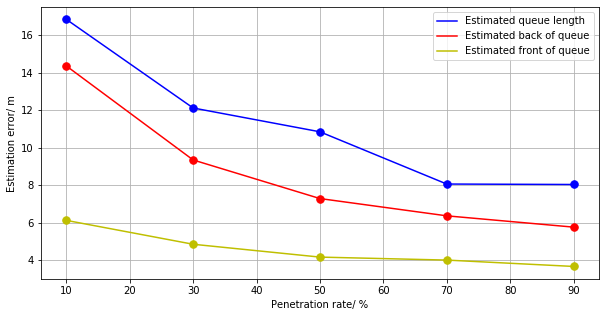

In [14]:
plt.figure(figsize=[10, 5])

pr = [10, 30, 50, 70, 90]

q_e = [16.84, 12.115, 10.845, 8.060, 8.036]
back_e = [14.358, 9.344, 7.286, 6.365, 5.763]
front_e = [6.123, 4.850, 4.165, 4.006, 3.667]

plt.plot(pr, q_e, 'b', label='Estimated queue length')
plt.plot(pr, q_e, 'b.', ms=15)
plt.plot(pr, back_e, 'r', label='Estimated back of queue')
plt.plot(pr, back_e, 'r.', ms=15)
plt.plot(pr, front_e, 'y', label='Estimated front of queue')
plt.plot(pr, front_e, 'y.', ms=15)
plt.grid()
plt.xlabel('Penetration rate/ %')
plt.ylabel('Estimation error/ m')
plt.legend()